
# Algoritmo K-means: Versión Serial y Paralela

## Introducción

El algoritmo **K-means** es uno de los métodos más populares y ampliamente usados en tareas de agrupamiento no supervisado (*clustering*). Su objetivo principal es organizar un conjunto de datos en grupos o *clusters*, donde cada observación pertenece al grupo cuyo centro (centroide) es el más cercano según una medida de distancia, comúnmente la distancia euclidiana.

En este notebook, presentaremos dos implementaciones del algoritmo K-means:

- **Versión Serial**: Una implementación sencilla del algoritmo sin optimizaciones especiales, ejecutada secuencialmente.
- **Versión Paralela**: Una versión optimizada utilizando OpenMP para aprovechar múltiples núcleos del CPU y reducir significativamente el tiempo de ejecución.

Ambas versiones han sido implementadas en C++.

---

## Descripción del Problema

Utilizaremos un archivo CSV que contiene una gran cantidad de puntos en dos dimensiones (X, Y). Nuestro objetivo es:

- Asignar cada punto a uno de \( k \) grupos.
- Determinar la posición de cada centroide de modo que la distancia total entre los puntos y sus centroides sea mínima.

Cada fila del archivo CSV tiene el siguiente formato:

```
X,Y
```

---

## Estructuras y Funciones Básicas (Comunes a ambas versiones)

Comencemos describiendo detalladamente las estructuras y funciones auxiliares comunes a ambas versiones (serial y paralela):

### Estructura `Point`

Esta estructura representa un punto en el espacio bidimensional:

```cpp
struct Point {
    double x;       // Coordenada X
    double y;       // Coordenada Y
    int cluster;    // Índice del cluster asignado al punto (inicialmente -1)

    Point(double x, double y) : x(x), y(y), cluster(-1) {}
};
```

- `x` y `y` almacenan la ubicación del punto en el plano 2D.
- `cluster` almacena el índice del centroide más cercano. Inicialmente, este valor es `-1`, indicando que el punto aún no está asignado.

---

### Estructura `Centroid`

Esta estructura representa un centroide, que actúa como centro de cada grupo de puntos:

```cpp
struct Centroid {
    double x;                 // Coordenada X del centroide
    double y;                 // Coordenada Y del centroide
    std::vector<int> points;  // Índices de los puntos asignados al centroide

    Centroid(double x, double y) : x(x), y(y) {}

    void clear() {
        points.clear();       // Limpia la asignación de puntos antes de cada iteración
    }
};
```

- `x` y `y` representan la posición actual del centroide.
- `points` es una lista con los índices de los puntos actualmente asignados a este centroide. Esta lista se reinicia en cada iteración del algoritmo mediante el método `clear()`.

---

### Función para Calcular Distancia Euclidiana

La función `distance` calcula la distancia euclidiana entre un punto y un centroide específico:

```cpp
double distance(const Point &point, const Centroid &centroid) {
    return std::sqrt(std::pow(point.x - centroid.x, 2) + 
                     std::pow(point.y - centroid.y, 2));
}
```

- Esta función es fundamental para determinar qué tan cerca está un punto respecto a cada centroide.
- La fórmula usada es la distancia euclidiana estándar:


$$
\text{distancia}(p, c) = \sqrt{(p_x - c_x)^2 + (p_y - c_y)^2}
$$

---

## Estrategia General del Algoritmo K-means (Serial)

La versión serial del algoritmo K-means sigue estos pasos generales:

1. **Inicializar centroides**:
   - Se seleccionan aleatoriamente \( k \) posiciones dentro del rango de los datos como centroides iniciales.

2. **Asignar puntos**:
   - Cada punto se asigna al centroide más cercano según la distancia euclidiana.

3. **Actualizar centroides**:
   - Se recalcula la posición de cada centroide como el promedio de todos los puntos asignados a él.

4. **Repetir pasos 2 y 3** hasta que:
   - Ningún punto cambie de grupo (convergencia), o se alcance el número máximo de iteraciones.

---

## Código Serial: Carga de Datos

El método `loadPoints` carga puntos desde un archivo CSV:

```cpp
bool loadPoints(const std::string &filename) {
    std::ifstream file(filename);
    if (!file.is_open()) {
        std::cerr << "Error: No se pudo abrir el archivo " << filename << std::endl;
        return false;
    }

    points.clear();
    std::string line;

    while (std::getline(file, line)) {
        std::stringstream ss(line);
        std::string x_str, y_str;

        if (std::getline(ss, x_str, ',') && std::getline(ss, y_str, ',')) {
            try {
                double x = std::stod(x_str);
                double y = std::stod(y_str);
                points.emplace_back(x, y);
            }
            catch (const std::exception &e) {
                std::cerr << "Error al convertir a número: " << e.what() << std::endl;
            }
        }
    }

    file.close();

    if (points.empty()) {
        std::cerr << "Error: No se cargaron puntos desde el archivo." << std::endl;
        return false;
    }

    return true;
}
```

- Este método lee línea por línea, separa por comas, convierte a números reales, y los almacena en un vector de `Point`.

## Guardar Resultados  

El método `saveResults` guarda los resultados en un archivo CSV:

```cpp
bool saveResults(const std::string &filename)
    {
        std::ofstream file(filename);
        if (!file.is_open())
        {
            std::cerr << "Error: No se pudo abrir el archivo " << filename << " para escritura." << std::endl;
            return false;
        }

        // Escribir cada punto con su cluster asignado
        for (const auto &point : points)
        {
            file << std::fixed << std::setprecision(3)
                 << point.x << ","
                 << point.y << ","
                 << point.cluster << std::endl;
        }

        file.close();
        return true;
    }

- Este método genera un archivo CSV con tres columnas (`x, y, cluster`) indicando la posición y asignación final de cada punto.


## Algoritmo K-means Serial: Detalle Paso a Paso del Código

### Paso 1: Inicialización Aleatoria de Centroides

El método `initializeCentroids` elige aleatoriamente \( k \) posiciones dentro del rango de valores de los puntos cargados:

```cpp
void initializeCentroids() {
    if (points.empty()) {
        std::cerr << "Error: No hay puntos para inicializar centroides." << std::endl;
        return;
    }

    centroids.clear();

    // Encontrar los mínimos y máximos en cada dimensión
    double min_x = std::numeric_limits<double>::max();
    double max_x = std::numeric_limits<double>::min();
    double min_y = std::numeric_limits<double>::max();
    double max_y = std::numeric_limits<double>::min();

    for (const auto &point : points) {
        min_x = std::min(min_x, point.x);
        max_x = std::max(max_x, point.x);
        min_y = std::min(min_y, point.y);
        max_y = std::max(max_y, point.y);
    }

    // Distribuciones uniformes para coordenadas aleatorias
    std::uniform_real_distribution<double> dist_x(min_x, max_x);
    std::uniform_real_distribution<double> dist_y(min_y, max_y);

    // Crear k centroides con posiciones aleatorias
    for (int i = 0; i < k; i++) {
        double x = dist_x(rng);
        double y = dist_y(rng);
        centroids.emplace_back(x, y);
    }
}
```

**Explicación:**

- Este método primero determina los valores mínimos y máximos en X y Y de los puntos cargados.
- Luego genera centroides en posiciones aleatorias, asegurando que estén distribuidos dentro del rango de los datos.

---

### Paso 2: Asignación de Puntos al Centroide más Cercano

El método `assignPointsToCentroids` asigna cada punto al centroide más cercano según la distancia euclidiana:

```cpp
bool assignPointsToCentroids() {
    bool changed = false;

    // Limpiar las asignaciones anteriores
    for (auto &centroid : centroids) {
        centroid.clear();
    }

    // Asignar cada punto al centroide más cercano
    for (size_t i = 0; i < points.size(); i++) {
        double min_distance = std::numeric_limits<double>::max();
        int closest_centroid = -1;

        // Calcular distancia a cada centroide
        for (size_t j = 0; j < centroids.size(); j++) {
            double dist = distance(points[i], centroids[j]);
            if (dist < min_distance) {
                min_distance = dist;
                closest_centroid = j;
            }
        }

        // Verificar y actualizar asignación del cluster
        if (closest_centroid != -1) {
            if (points[i].cluster != closest_centroid) {
                changed = true; // Indica que hubo un cambio de asignación
                points[i].cluster = closest_centroid;
            }
            centroids[closest_centroid].points.push_back(i);
        }
    }

    return changed;
}
```

**Explicación:**

- Para cada punto, se determina cuál es el centroide más cercano según la distancia euclidiana.
- Si la asignación del punto cambia respecto a la iteración anterior, `changed` se vuelve verdadero.
- Cada centroide guarda los índices de los puntos que le pertenecen.

---

### Paso 3: Actualización de las posiciones de los centroides

El método `updateCentroids` actualiza la posición de cada centroide usando la media de todos los puntos asignados a él:

```cpp
void updateCentroids() {
    for (size_t i = 0; i < centroids.size(); i++) {
        if (centroids[i].points.empty()) {
            continue; // Si no tiene puntos asignados, no actualizar posición
        }

        double sum_x = 0.0;
        double sum_y = 0.0;

        // Calcular el promedio de las posiciones de los puntos asignados
        for (size_t j = 0; j < centroids[i].points.size(); j++) {
            int point_idx = centroids[i].points[j];
            sum_x += points[point_idx].x;
            sum_y += points[point_idx].y;
        }

        // Actualizar la posición del centroide
        centroids[i].x = sum_x / centroids[i].points.size();
        centroids[i].y = sum_y / centroids[i].points.size();
    }
}
```

**Explicación:**

- Para cada centroide, se suman las coordenadas de los puntos asignados.
- La nueva posición del centroide es el promedio de estas coordenadas.
- Esto asegura que el centroide se mueva hacia el centro del grupo de puntos.

---

### Ejecución del Algoritmo

Finalmente, la función `run` controla el flujo general del algoritmo:

```cpp
void run(int max_iterations = 100) {
    if (points.empty() || k <= 0) {
        std::cerr << "Error: No hay puntos o el número de clusters es inválido." << std::endl;
        return;
    }

    initializeCentroids();

    bool changed = true;
    int iteration = 0;

    // Iterar hasta convergencia o máximo de iteraciones
    while (changed && iteration < max_iterations) {
        changed = assignPointsToCentroids();
        updateCentroids();
        iteration++;
    }
}
```

**Explicación:**

- Se inicializan los centroides una sola vez al comienzo.
- Luego, se repiten los pasos de asignación y actualización hasta que ningún punto cambie de cluster o se alcance un máximo número de iteraciones definido.



# Algoritmo K-means Paralelo con OpenMP

## Estrategia de Paralelización

La paralelización del algoritmo K-means utilizando **OpenMP** busca reducir considerablemente el tiempo de ejecución al aprovechar múltiples núcleos del procesador. A continuación, se describe la estrategia utilizada para paralelizar cada etapa del algoritmo.

### Razones para Paralelizar:

El algoritmo K-means es adecuado para paralelizar porque:

- **Independencia de cálculos**: Las distancias entre puntos y centroides se pueden calcular en paralelo, ya que cada cálculo es independiente.
- **Alta carga computacional**: En datasets grandes, el tiempo que tarda el cálculo de distancias domina la ejecución, beneficiándose así enormemente del paralelismo.

---

## Paralelización Paso a Paso

### 1. Inicialización Paralela de Centroides

El cálculo del rango de los datos para inicializar los centroides se hace en paralelo mediante la cláusula `reduction` de OpenMP:

```cpp
#pragma omp parallel for reduction(min : min_x, min_y) reduction(max : max_x, max_y)
for (size_t i = 0; i < points.size(); i++)
{
    min_x = std::min(min_x, points[i].x);
    max_x = std::max(max_x, points[i].x);
    min_y = std::min(min_y, points[i].y);
    max_y = std::max(max_y, points[i].y);
}
```

**Explicación:**

- Cada hilo encuentra el mínimo y máximo localmente, y luego OpenMP reduce automáticamente estos valores a mínimos y máximos globales.
- Esto reduce el tiempo de encontrar los límites de los datos considerablemente.

---



### 2. Asignación Paralela de Puntos a Centroides

Este paso tiene una carga computacional alta y es ideal para paralelizar.

### 1. Inicialización
```cpp
bool changed = false;

// Limpiar las asignaciones anteriores
for (auto &centroid : centroids) {
    centroid.clear();
}
```
- Se inicializa `changed` como `false` para rastrear si algún punto cambió de cluster
- Se limpian las asignaciones previas de puntos a centroides

### 2. Preparación de locks
```cpp
std::vector<omp_lock_t> centroid_locks(centroids.size());
for (size_t i = 0; i < centroids.size(); i++) {
    omp_init_lock(&centroid_locks[i]);
}
```
- Se crea un lock (mutex) para cada centroide
- Estos locks evitarán que varios hilos modifiquen el mismo centroide simultáneamente

### 3. Región paralela principal
```cpp
#pragma omp parallel reduction(|| : changed)
```
- Se crea una región paralela donde múltiples hilos trabajarán
- `reduction(|| : changed)` significa que cada hilo tendrá su propia copia de `changed` y al final se combinarán mediante OR lógico (`||`)

### 4. Información del hilo
```cpp
int actual_threads = omp_get_num_threads();
int thread_id = omp_get_thread_num();
```
- Se obtiene el número total de hilos y el ID del hilo actual
- Aunque estas variables no se usan explícitamente, son útiles para depuración

### 5. Memoria local por hilo
```cpp
std::vector<std::vector<int>> local_centroid_points(centroids.size());
```
- Cada hilo crea su propia estructura para almacenar temporalmente los índices de puntos asignados a cada centroide
- Esto evita contención por recursos compartidos durante la fase de asignación

### 6. Distribución del trabajo entre hilos
```cpp
#pragma omp for
for (size_t i = 0; i < points.size(); i++) {
    // código de asignación
}
```
- La directiva `#pragma omp for` distribuye las iteraciones del bucle entre los hilos disponibles
- Cada hilo procesa un conjunto diferente de puntos

### 7. Asignación de puntos
```cpp
double min_distance = std::numeric_limits<double>::max();
int closest_centroid = -1;

for (size_t j = 0; j < centroids.size(); j++) {
    double dist = distance(points[i], centroids[j]);
    if (dist < min_distance) {
        min_distance = dist;
        closest_centroid = j;
    }
}
```
- Para cada punto, se encuentra el centroide más cercano calculando todas las distancias
- La función `distance` calcula la distancia euclidiana entre un punto y un centroide

### 8. Actualización de asignaciones
```cpp
if (closest_centroid != -1) {
    // Verificar si la asignación del cluster cambió
    if (points[i].cluster != closest_centroid) {
        changed = true;
        points[i].cluster = closest_centroid;
    }
    // Almacenar el punto localmente para este hilo
    local_centroid_points[closest_centroid].push_back(i);
}
```
- Si el cluster asignado ha cambiado, se actualiza la variable `changed` a `true`
- El punto se añade a la estructura local del hilo para ese centroide
- Modificar el array `points` es seguro porque cada hilo trabaja en diferentes elementos

### 9. Combinación de resultados locales
```cpp
for (size_t j = 0; j < centroids.size(); j++) {
    if (!local_centroid_points[j].empty()) {
        omp_set_lock(&centroid_locks[j]);
        centroids[j].points.insert(
            centroids[j].points.end(),
            local_centroid_points[j].begin(),
            local_centroid_points[j].end());
        omp_unset_lock(&centroid_locks[j]);
    }
}
```
- Una vez que cada hilo ha procesado sus puntos, combina sus resultados locales con la estructura global
- Para cada centroide, si hay puntos asignados localmente:
  - Se adquiere el lock específico para ese centroide
  - Se insertan los puntos locales en el vector global del centroide
  - Se libera el lock

### 10. Limpieza de locks
```cpp
for (size_t i = 0; i < centroids.size(); i++) {
    omp_destroy_lock(&centroid_locks[i]);
}
```
- Se destruyen todos los locks creados para liberar recursos

### 11. Resultado
```cpp
return changed;
```
- Se devuelve el valor de `changed`, que indica si al menos un punto cambió de cluster

### ¿Por qué está implementado así?

1. **Minimiza contención**: Al usar estructuras locales por hilo, se reduce la contención por acceso a memoria compartida.

2. **Granularidad fina de locks**: En lugar de bloquear todo el array de centroides, se usa un lock por centroide.

3. **Reduce operaciones de sincronización**: La mayor parte del trabajo se hace de forma independiente, y solo se sincroniza al final.

4. **Localidad de memoria**: Cada hilo accede a su propia memoria, mejorando el rendimiento de caché.

5. **Procesamiento de datos eficiente**: La estructura `local_centroid_points` permite acumular resultados antes de actualizaciones costosas.

Esta implementación equilibra paralelismo con la necesidad de consistencia de datos, maximizando el rendimiento en sistemas multicore.

### 3. Actualización Paralela de Posiciones de Centroides

La actualización de los centroides se paraleliza asignando cada centroide a un hilo distinto mediante una simple directiva OpenMP:

```cpp
#pragma omp parallel for
for (size_t i = 0; i < centroids.size(); i++) {
    if (centroids[i].points.empty()) {
        continue;
    }

    double sum_x = 0.0, sum_y = 0.0;
    size_t count = centroids[i].points.size();

    // Sumar posiciones asignadas (sin paralelismo anidado para simplificar)
    for (size_t j = 0; j < count; j++) {
        int point_idx = centroids[i].points[j];
        sum_x += points[point_idx].x;
        sum_y += points[point_idx].y;
    }

    // Actualización final del centroide
    centroids[i].x = sum_x / count;
    centroids[i].y = sum_y / count;
}
```

**Explicación:**

- Dado que la actualización de cada centroide es independiente, se paraleliza fácilmente sin riesgos.
- Evitamos paralelismo anidado aquí para mantener la complejidad baja, dado que la actualización por centroide es relativamente rápida.

---

## Manejo de Hilos con OpenMP

La clase paralela incluye métodos adicionales para gestionar fácilmente el número de hilos:

```cpp
// Establecer número de hilos
void setNumThreads(int threads) {
    num_threads = threads;
    omp_set_num_threads(num_threads);
}

// Obtener número de hilos actual
int getNumThreads() const {
    return num_threads;
}
```

**Explicación:**

- Permiten ajustar fácilmente el número de hilos utilizados según la capacidad del sistema.

---

## Resultados y Medición del Rendimiento

Para medir el tiempo de ejecución, se utiliza la función de tiempo proporcionada por OpenMP (`omp_get_wtime()`):

```cpp
double start_time = omp_get_wtime();

kmeans.run(max_iterations);

double end_time = omp_get_wtime();
double elapsed_time = (end_time - start_time) * 1000.0; // ms

std::cout << "Tiempo total del algoritmo K-means paralelo: " 
          << elapsed_time << " ms" << std::endl;
```

**Explicación:**

- Se mide precisamente el tiempo total del algoritmo paralelo, facilitando comparaciones claras con la versión serial.



# **Acordeón del código K-means (Serial y Paralelo)**

## **Estructuras principales**

| Estructura | Campos principales | Propósito | Razón de elección |
|------------|--------------------|-----------|-------------------|
| `Point`    | `double x, y; int cluster` | Almacena coordenadas (x,y) de un punto y su asignación a un cluster. | Estructura sencilla que facilita acceder a posiciones y asignaciones. |
| `Centroid` | `double x, y; vector<int> points` | Guarda la posición del centroide y los índices de puntos asignados. | Permite actualizar eficientemente centroides al calcular medias, accediendo fácilmente a los puntos asignados. |

---

## **Funciones comunes (Serial y Paralelo)**

| Función | Entrada | Salida | ¿Qué hace? | ¿Por qué así? |
|---------|---------|--------|------------|---------------|
| `distance()` | `Point`, `Centroid` | `double` | Calcula distancia euclidiana entre un punto y un centroide. | Función sencilla e inline por rendimiento. |
| `loadPoints()` | Archivo CSV | `bool` | Carga puntos desde archivo CSV a memoria. | Fácil manejo de entrada con formato estándar CSV. |
| `saveResults()` | Nombre archivo CSV | `bool` | Guarda resultados de clustering en CSV (puntos y su cluster). | Facilita visualización y análisis posterior externo. |

---

## **Funciones versión Serial**

| Función | ¿Qué hace? | Estructuras que usa | ¿Por qué así? |
|---------|------------|---------------------|---------------|
| `initializeCentroids()` | Inicializa centroides aleatorios dentro del rango de datos. | `vector<Centroid>` | Aleatoriedad ayuda a evitar sesgos iniciales. |
| `assignPointsToCentroids()` | Asigna cada punto al centroide más cercano. | `vector<Point>`, `vector<Centroid>` | Uso directo de listas permite asignaciones y actualizaciones rápidas en forma secuencial. |
| `updateCentroids()` | Actualiza centroides a la posición media de sus puntos. | `vector<Point>`, `vector<Centroid>` | Actualización sencilla con sumas y promedios para garantizar convergencia rápida. |
| `run()` | Ejecuta el flujo completo del algoritmo. | Todas las anteriores | Organización clara del proceso iterativo hasta convergencia. |

---

## **Funciones versión Paralela (OpenMP)**

| Función | ¿Qué hace? | Estructuras que usa | ¿Por qué así? (paralelización) |
|---------|------------|---------------------|--------------------------------|
| `initializeCentroids()` | Encuentra rango de datos y genera centroides iniciales aleatorios. | `vector<Point>`, `vector<Centroid>` | **Paraleliza búsqueda de mínimos y máximos con `reduction`.** Reduce tiempo de ejecución significativamente. |
| `assignPointsToCentroids()` | Asigna cada punto al centroide más cercano. | `vector<Point>`, `vector<Centroid>`, `vector<omp_lock_t>` | **Utiliza estructuras locales por hilo y locks** para evitar condiciones de carrera. Asignación altamente paralelizable. |
| `updateCentroids()` | Calcula nueva posición media de centroides con puntos asignados. | `vector<Point>`, `vector<Centroid>` | **Paraleliza directamente sobre centroides**, ya que su actualización es independiente y no requiere sincronización compleja. |
| `run()` | Ejecuta la lógica completa del algoritmo con convergencia paralela. | Todas las anteriores | Gestiona claramente la convergencia usando paralelización para máximo rendimiento. |
| `setNumThreads()` y `getNumThreads()` | Maneja número de hilos usados por OpenMP. | Variable `num_threads` | Control dinámico del nivel de paralelismo según hardware disponible. |

---


# Entorno de Ejecución de los Experimentos

## Hardware
Los experimentos se llevaron a cabo en un equipo con las siguientes especificaciones:

| Componente | Especificación |
|------------|----------------|
| **Equipo** | Acer Nitro AN515-54 |
| **Procesador** | Intel Core i7-9750H @ 2.59 GHz |
| **Memoria RAM** | 16 GB |
| **Arquitectura** | 64 bits |

## Software

| Componente | Especificación |
|------------|----------------|
| **Sistema Operativo** | Windows 11 Home Single Language (versión 10.0.22631) |
| **Entorno de Ejecución** | WSL2 (Windows Subsystem for Linux 2) |
| **Distribución Linux** | Ubuntu 22.04.3 LTS |
| **Kernel** | Linux 5.15.153.1-microsoft-standard-WSL2 |

El uso de WSL2 permitió aprovechar las herramientas y bibliotecas del ecosistema Linux directamente desde Windows, facilitando el desarrollo y la ejecución de los experimentos en un entorno de computación paralela.

Nombres de columnas originales: ['Puntos', 'Hilos', 'Tiempo Serial (ms)', 'Tiempo Paralelo (ms)', 'Speedup ']
Nombres de columnas limpios: ['Puntos', 'Hilos', 'Tiempo Serial (ms)', 'Tiempo Paralelo (ms)', 'Speedup']


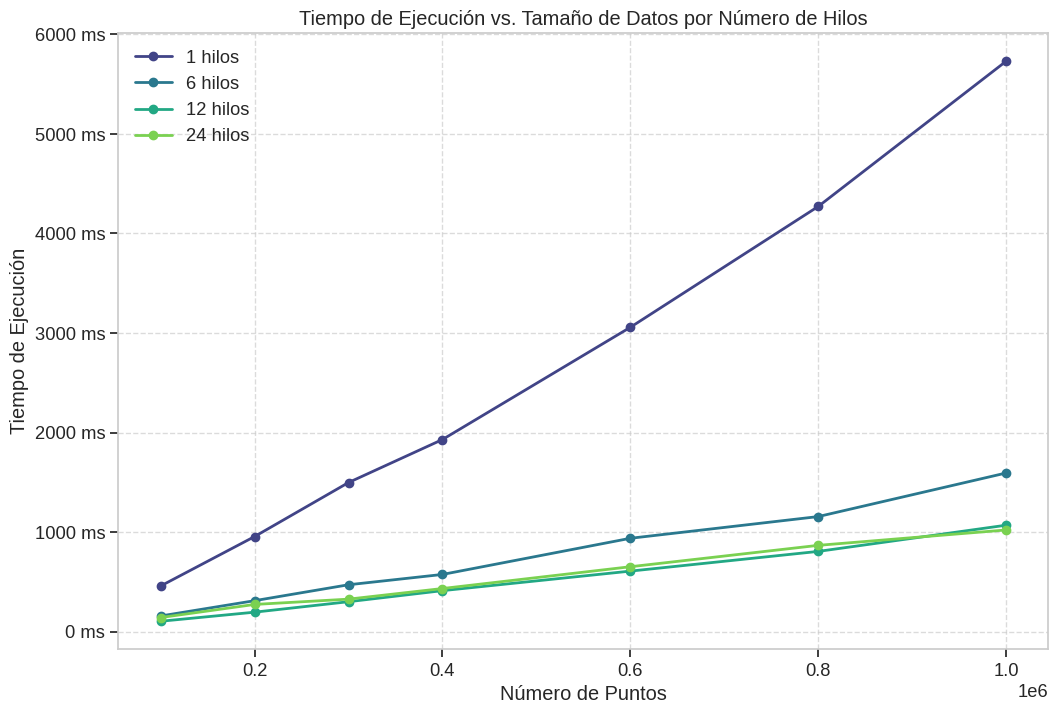

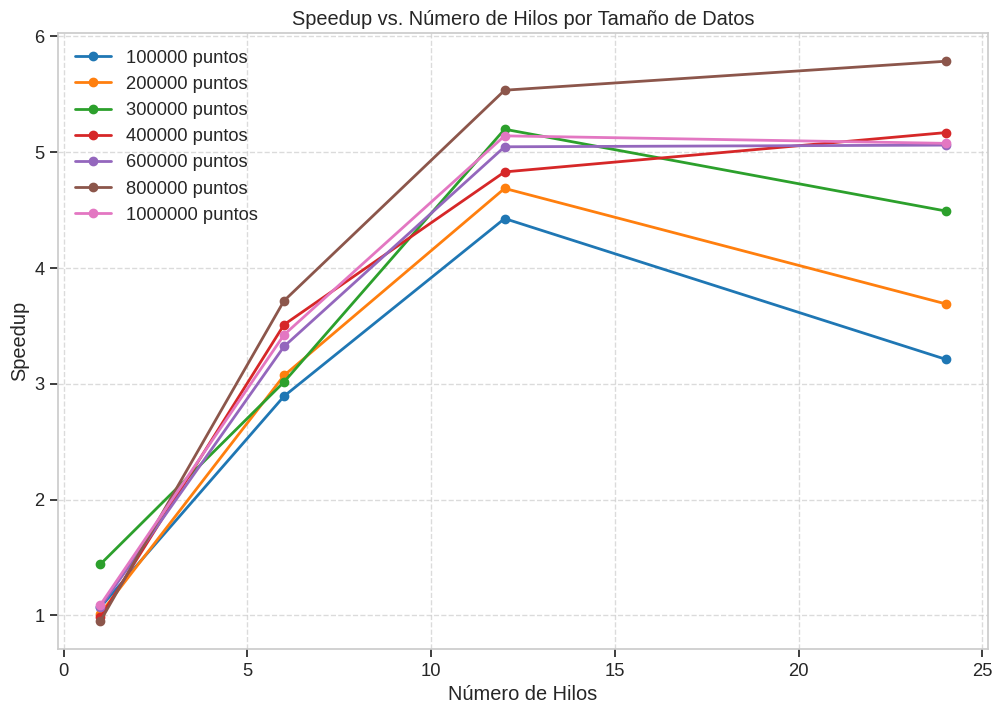

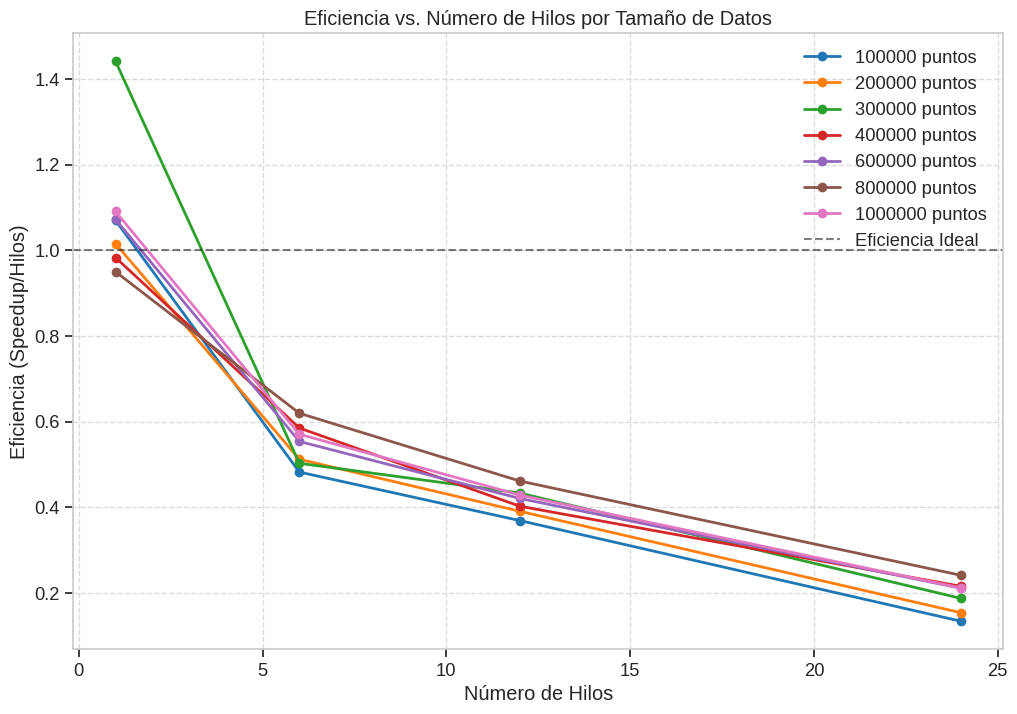

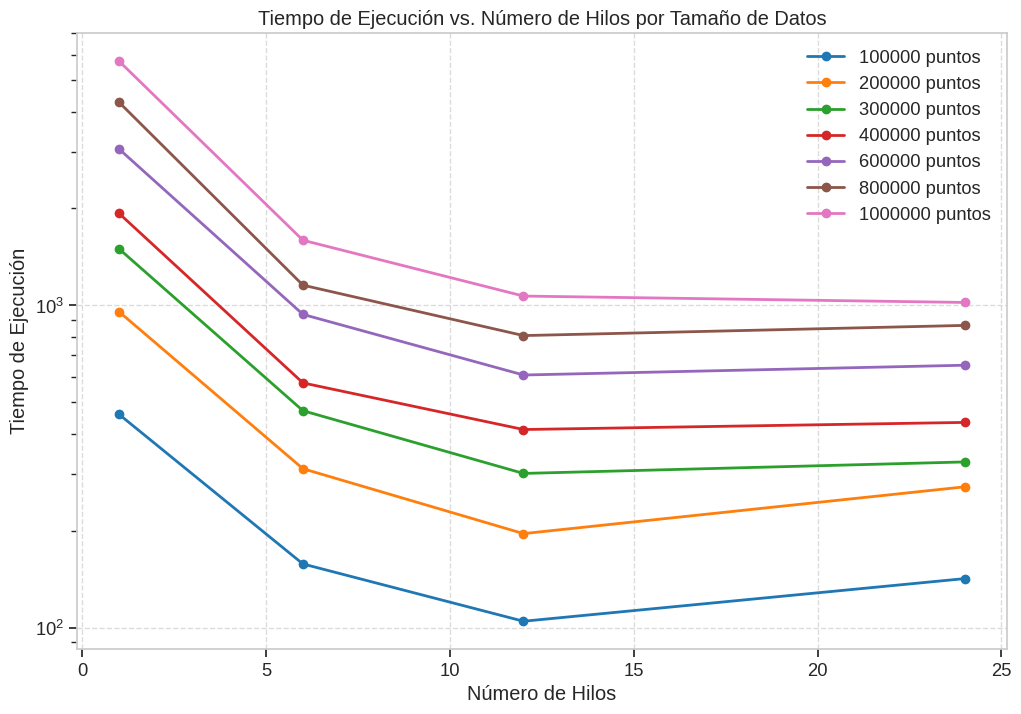

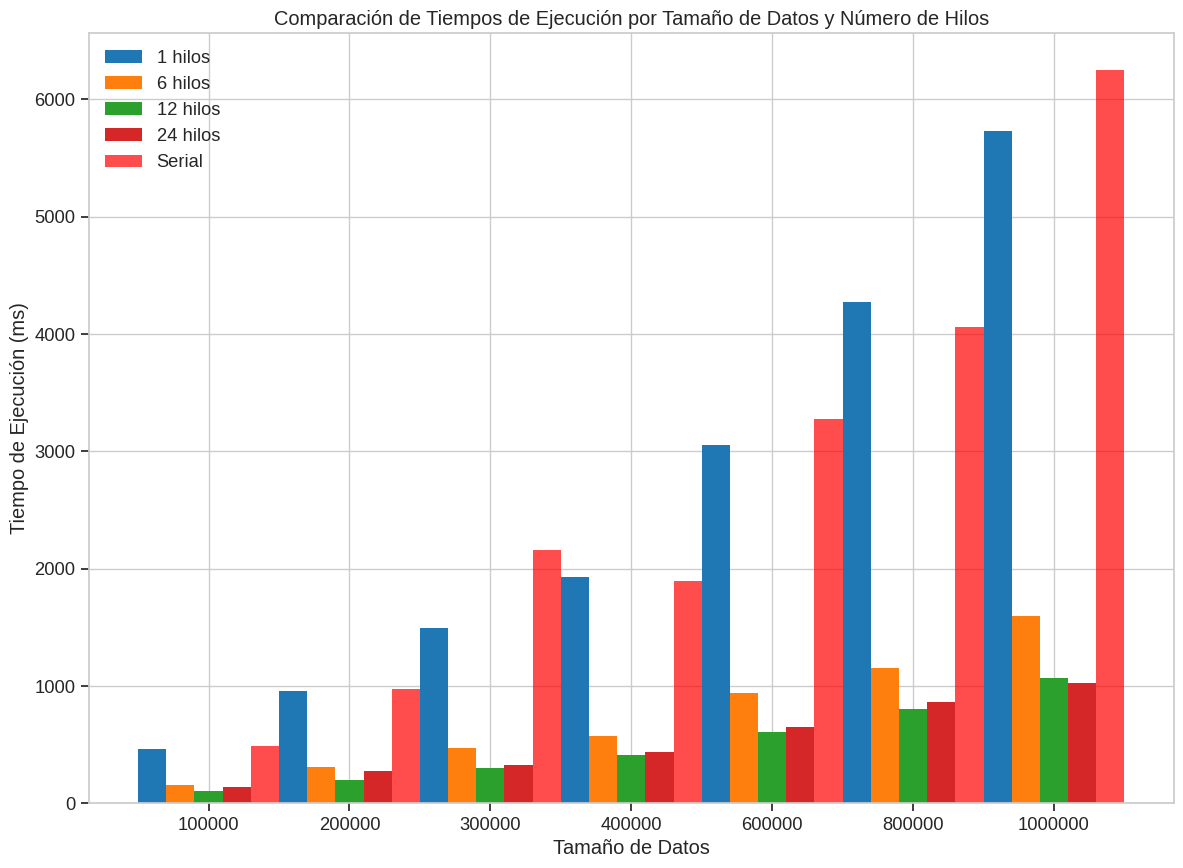

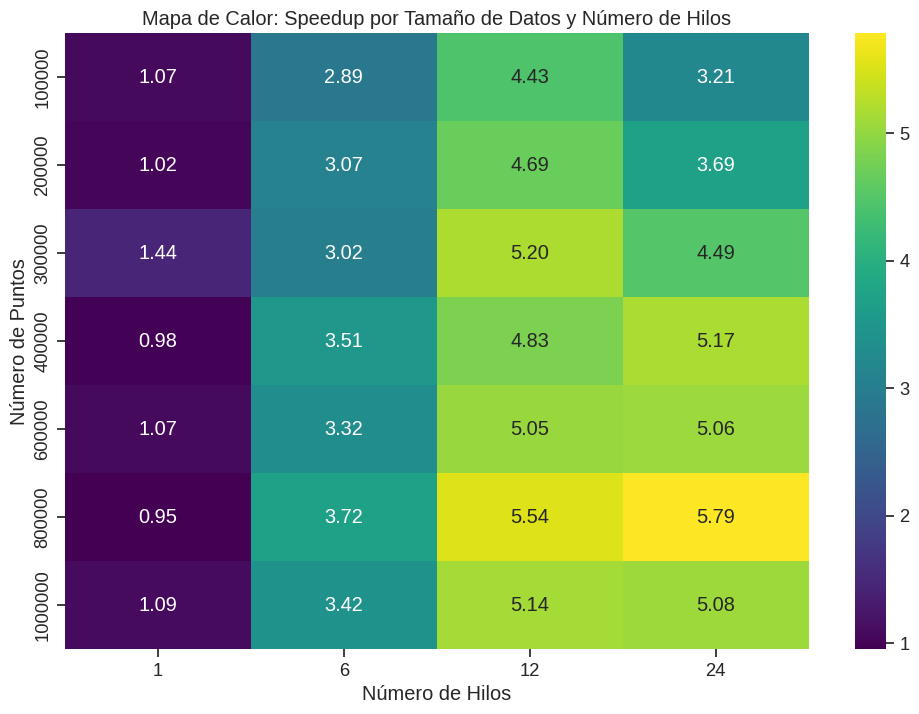

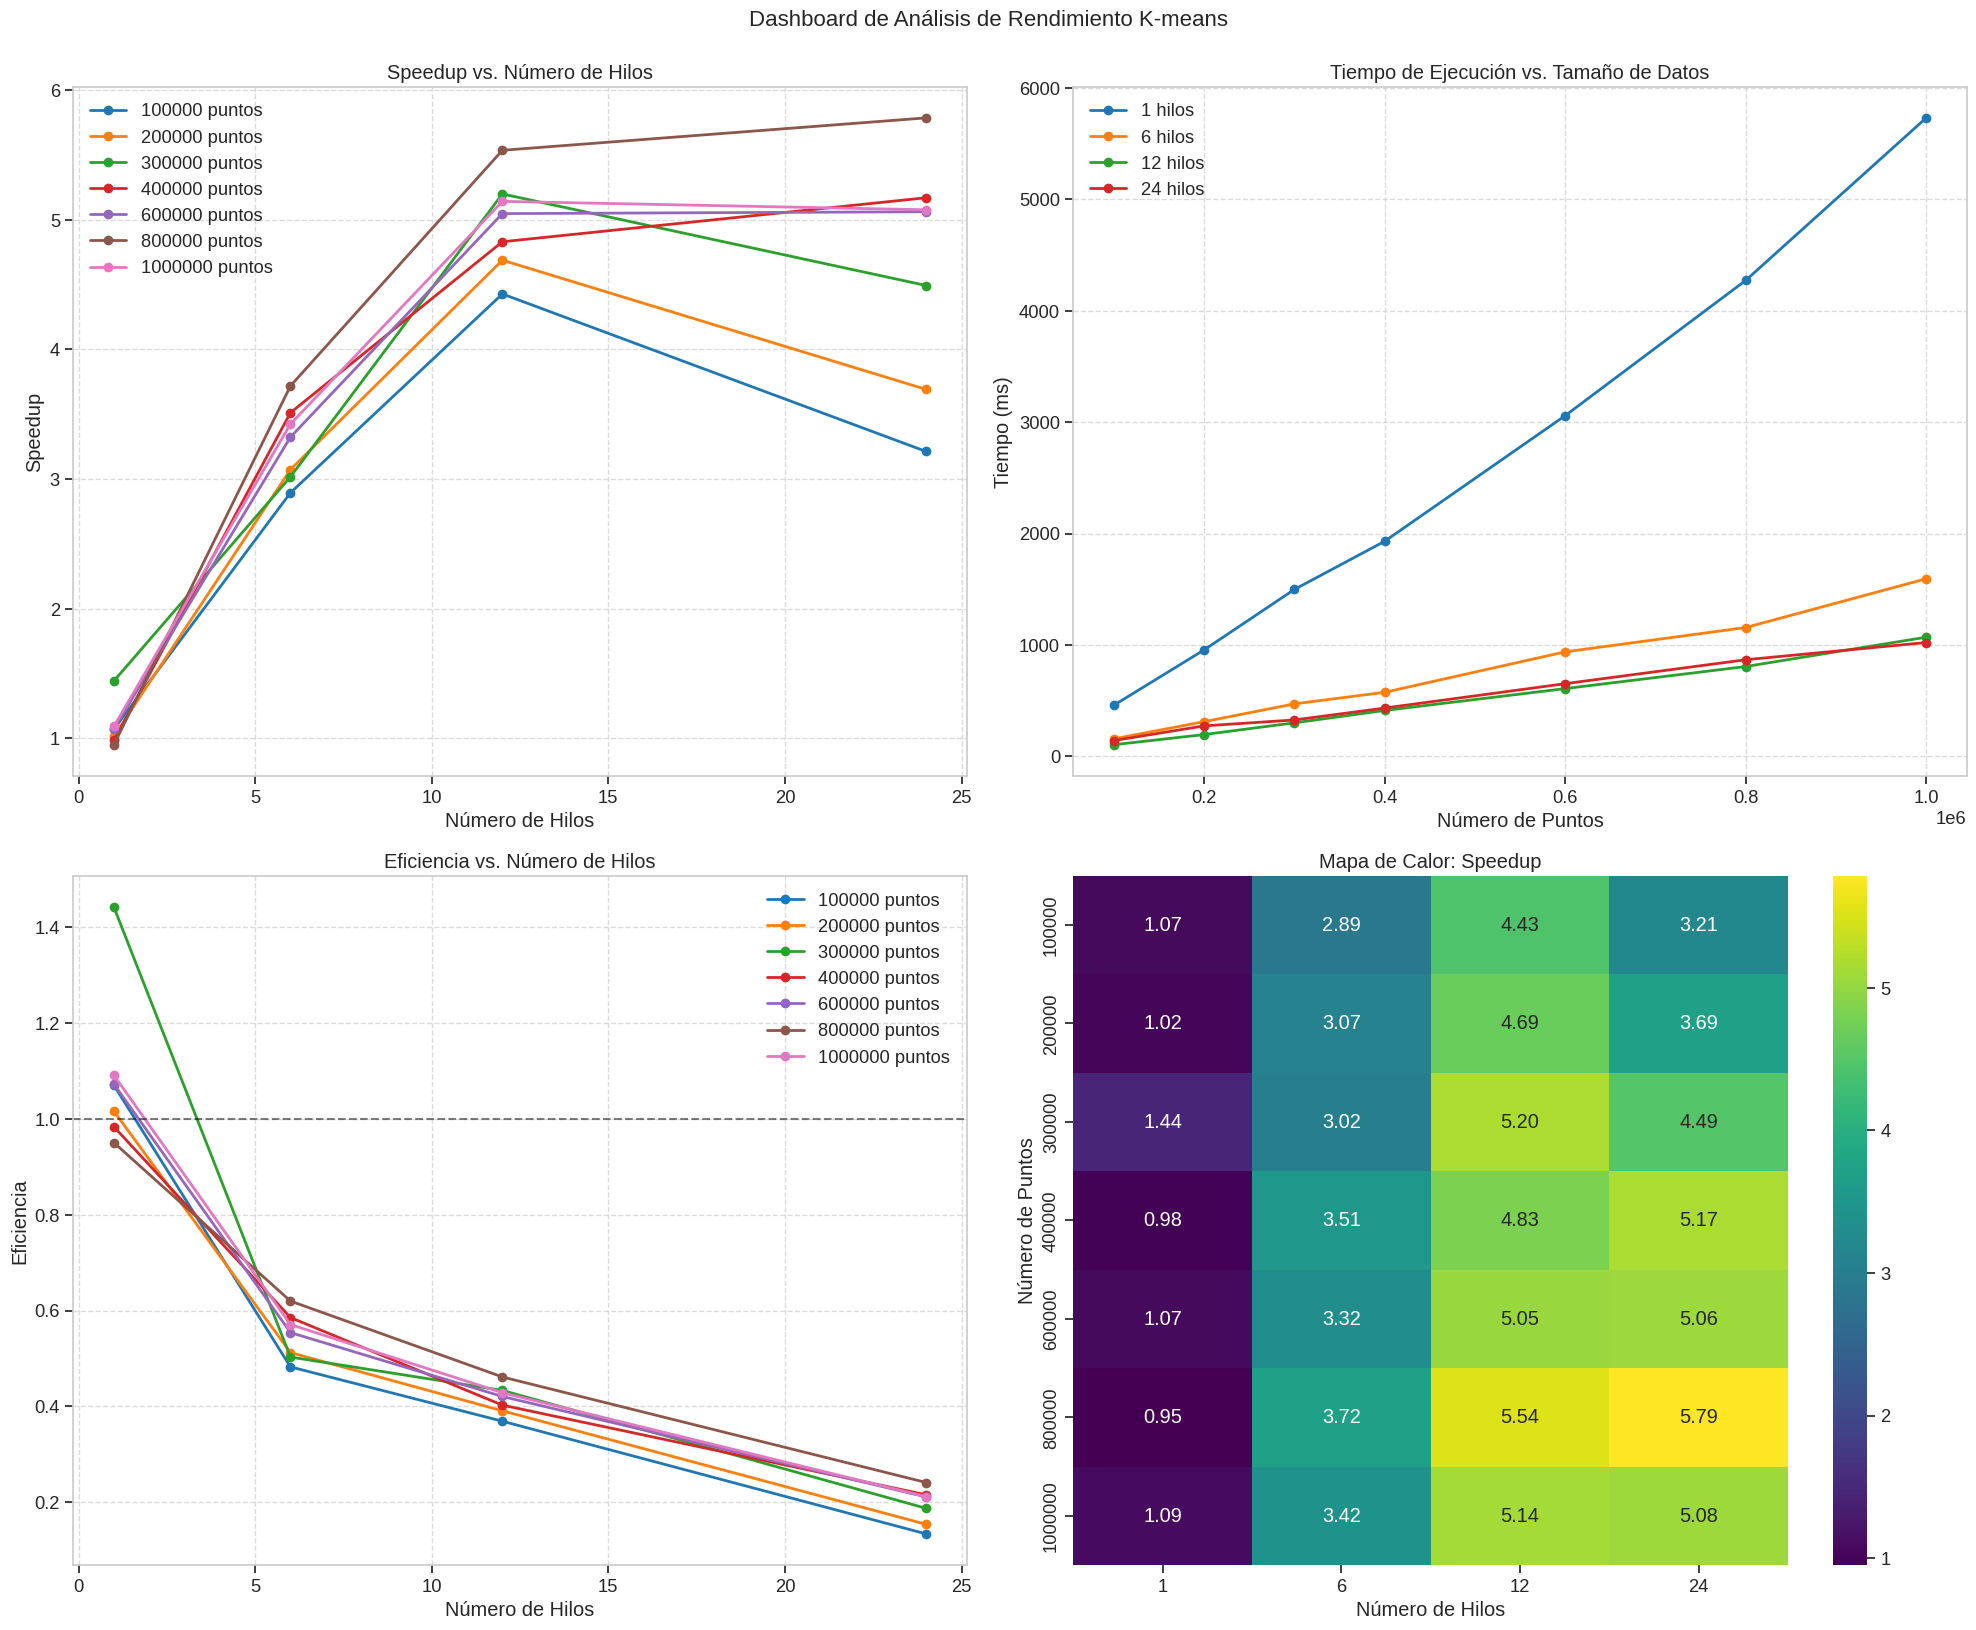

¡Visualizaciones generadas con éxito!


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.gridspec import GridSpec

# Cargar los datos
df = pd.read_csv('/home/cord2108/ITAM/Paralelo/proyecto/benchmark_results.csv')

# Inspeccionar los nombres de las columnas para depuración
print("Nombres de columnas originales:", df.columns.tolist())

# Limpiar los nombres de las columnas (eliminar espacios)
df.columns = df.columns.str.strip()
print("Nombres de columnas limpios:", df.columns.tolist())

# Configuración de estilo para las gráficas
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
colors = sns.color_palette("viridis", 4)

# Función para formatear los valores del eje y en milisegundos
def format_time(x, pos):
    return f'{x:.0f} ms'

# 1. Gráfica de tiempo de ejecución vs. tamaño de datos para cada configuración de hilos
fig1, ax1 = plt.subplots(figsize=(12, 8))

# Agrupar por tamaño de puntos y número de hilos
sizes = sorted(df['Puntos'].unique())
threads = sorted(df['Hilos'].unique())

for i, thread in enumerate(threads):
    thread_data = df[df['Hilos'] == thread]
    ax1.plot(thread_data['Puntos'], thread_data['Tiempo Paralelo (ms)'], 
             marker='o', linewidth=2, label=f'{thread} hilos', color=colors[i])
ax1.set_xlabel('Número de Puntos')
ax1.set_ylabel('Tiempo de Ejecución')
ax1.set_title('Tiempo de Ejecución vs. Tamaño de Datos por Número de Hilos')
ax1.yaxis.set_major_formatter(FuncFormatter(format_time))
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

# 2. Gráfica de speedup vs. número de hilos para cada tamaño de datos
fig2, ax2 = plt.subplots(figsize=(12, 8))

for i, size in enumerate(sizes):
    size_data = df[df['Puntos'] == size]
    ax2.plot(size_data['Hilos'], size_data['Speedup'], 
             marker='o', linewidth=2, label=f'{size} puntos')

# ELIMINADO: Línea de speedup ideal

ax2.set_xlabel('Número de Hilos')
ax2.set_ylabel('Speedup')
ax2.set_title('Speedup vs. Número de Hilos por Tamaño de Datos')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()

# 3. Gráfica de eficiencia vs. número de hilos para cada tamaño de datos
fig3, ax3 = plt.subplots(figsize=(12, 8))

for i, size in enumerate(sizes):
    size_data = df[df['Puntos'] == size]
    # Eficiencia = Speedup / Número de hilos
    efficiency = size_data['Speedup'] / size_data['Hilos']
    ax3.plot(size_data['Hilos'], efficiency, 
             marker='o', linewidth=2, label=f'{size} puntos')

ax3.set_xlabel('Número de Hilos')
ax3.set_ylabel('Eficiencia (Speedup/Hilos)')
ax3.set_title('Eficiencia vs. Número de Hilos por Tamaño de Datos')
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Eficiencia Ideal')
ax3.legend()

# 4. Gráfica de tiempo de ejecución vs. número de hilos para cada tamaño de datos
fig4, ax4 = plt.subplots(figsize=(12, 8))

for i, size in enumerate(sizes):
    size_data = df[df['Puntos'] == size]
    ax4.plot(size_data['Hilos'], size_data['Tiempo Paralelo (ms)'], 
             marker='o', linewidth=2, label=f'{size} puntos')

ax4.set_xlabel('Número de Hilos')
ax4.set_ylabel('Tiempo de Ejecución')
ax4.yaxis.set_major_formatter(FuncFormatter(format_time))
ax4.set_title('Tiempo de Ejecución vs. Número de Hilos por Tamaño de Datos')
ax4.grid(True, linestyle='--', alpha=0.7)
ax4.legend()

# Escala logarítmica para mejor visualización
ax4.set_yscale('log')

# 5. Gráfica de barras comparando tiempos seriales y paralelos para cada configuración
fig5, ax5 = plt.subplots(figsize=(14, 10))

# Preparar datos para gráfico de barras agrupadas
bar_width = 0.2
index = np.arange(len(sizes))

for i, thread in enumerate(threads):
    thread_data = df[df['Hilos'] == thread]
    thread_data = thread_data.sort_values('Puntos')
    
    ax5.bar(index + i*bar_width, thread_data['Tiempo Paralelo (ms)'], 
            bar_width, label=f'{thread} hilos')

# Agregar tiempo serial
serial_times = []
for size in sizes:
    serial_time = df[(df['Puntos'] == size) & (df['Hilos'] == 1)]['Tiempo Serial (ms)'].values[0]
    serial_times.append(serial_time)
    
ax5.bar(index + len(threads)*bar_width, serial_times, bar_width, label='Serial', color='red', alpha=0.7)

ax5.set_xlabel('Tamaño de Datos')
ax5.set_ylabel('Tiempo de Ejecución (ms)')
ax5.set_title('Comparación de Tiempos de Ejecución por Tamaño de Datos y Número de Hilos')
ax5.set_xticks(index + bar_width * (len(threads)/2))
ax5.set_xticklabels([f'{size}' for size in sizes])
ax5.legend()

# 6. Mapa de calor de speedup por tamaño de datos y número de hilos
pivot_df = df.pivot(index="Puntos", columns="Hilos", values="Speedup")

fig6, ax6 = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="viridis", ax=ax6)
ax6.set_title('Mapa de Calor: Speedup por Tamaño de Datos y Número de Hilos')
ax6.set_ylabel('Número de Puntos')
ax6.set_xlabel('Número de Hilos')

# 7. Dashboard con gráficas combinadas
fig7 = plt.figure(figsize=(20, 16))
gs = GridSpec(2, 2, figure=fig7)

# Speedup vs hilos
ax7_1 = fig7.add_subplot(gs[0, 0])
for i, size in enumerate(sizes):
    size_data = df[df['Puntos'] == size]
    ax7_1.plot(size_data['Hilos'], size_data['Speedup'], 
             marker='o', linewidth=2, label=f'{size} puntos')
# ELIMINADO: Línea de speedup ideal
ax7_1.set_xlabel('Número de Hilos')
ax7_1.set_ylabel('Speedup')
ax7_1.set_title('Speedup vs. Número de Hilos')
ax7_1.grid(True, linestyle='--', alpha=0.7)
ax7_1.legend()

# Tiempo vs tamaño
ax7_2 = fig7.add_subplot(gs[0, 1])
for i, thread in enumerate(threads):
    thread_data = df[df['Hilos'] == thread]
    ax7_2.plot(thread_data['Puntos'], thread_data['Tiempo Paralelo (ms)'], 
             marker='o', linewidth=2, label=f'{thread} hilos')
ax7_2.set_xlabel('Número de Puntos')
ax7_2.set_ylabel('Tiempo (ms)')
ax7_2.set_title('Tiempo de Ejecución vs. Tamaño de Datos')
ax7_2.grid(True, linestyle='--', alpha=0.7)
ax7_2.legend()

# Eficiencia
ax7_3 = fig7.add_subplot(gs[1, 0])
for i, size in enumerate(sizes):
    size_data = df[df['Puntos'] == size]
    efficiency = size_data['Speedup'] / size_data['Hilos']
    ax7_3.plot(size_data['Hilos'], efficiency, 
             marker='o', linewidth=2, label=f'{size} puntos')
ax7_3.set_xlabel('Número de Hilos')
ax7_3.set_ylabel('Eficiencia')
ax7_3.set_title('Eficiencia vs. Número de Hilos')
ax7_3.grid(True, linestyle='--', alpha=0.7)
ax7_3.axhline(y=1, color='k', linestyle='--', alpha=0.5)
ax7_3.legend()

# Mapa de calor
ax7_4 = fig7.add_subplot(gs[1, 1])
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="viridis", ax=ax7_4)
ax7_4.set_title('Mapa de Calor: Speedup')
ax7_4.set_ylabel('Número de Puntos')
ax7_4.set_xlabel('Número de Hilos')

plt.tight_layout()
fig7.suptitle('Dashboard de Análisis de Rendimiento K-means', fontsize=16, y=1.02)

# Mostrar todas las gráficas
plt.show()

print("¡Visualizaciones generadas con éxito!")